Timestamp

Age

Gender

Country

state: If you live in the United States, which state or territory do you live in?

self_employed: Are you self-employed?

family_history: Do you have a family history of mental illness?

treatment: Have you sought treatment for a mental health condition?

work_interfere: If you have a mental health condition, do you feel that it interferes with your work?

no_employees: How many employees does your company or organization have?

remote_work: Do you work remotely (outside of an office) at least 50% of the time?

tech_company: Is your employer primarily a tech company/organization?

benefits: Does your employer provide mental health benefits?

care_options: Do you know the options for mental health care your employer provides?

wellness_program: Has your employer ever discussed mental health as part of an employee wellness program?

seek_help: Does your employer provide resources to learn more about mental health issues and how to seek help?

anonymity: Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources?

leave: How easy is it for you to take medical leave for a mental health condition?

**mentalhealthconsequence**: Do you think that discussing a mental health issue with your employer would have negative consequences?

**physhealthconsequence**: Do you think that discussing a physical health issue with your employer would have negative consequences?

**coworkers: Would you be willing to discuss a mental health issue with your coworkers?

supervisor: Would you be willing to discuss a mental health issue with your direct supervisor(s)?

***mentalhealthinterview***: Would you bring up a mental health issue with a potential employer in an interview?

physhealthinterview: Would you bring up a physical health issue with a potential employer in an interview?

mentalvsphysical: Do you feel that your employer takes mental health as seriously as physical health?

obs_consequence: Have you heard of or observed negative consequences for coworkers with mental health conditions in your workplace?

comments: Any additional notes or comments

## Let's try to find out if a person, given other parameteres, would bring up a mental health issue to the employee

[Source: https://www.kaggle.com/osmi/mental-health-in-tech-survey]

In [95]:
import pandas as pd
import numpy as np
import os
import missingno as mn

from sklearn.model_selection import train_test_split


In [96]:
#finding path, ugh don't ask!
path, file = os.path.split(os.path.abspath("employee_mental_health.csv"))
path = path+'\data\\'

#loading data
data = pd.read_csv(path+file)
data.shape

(1259, 27)

In [97]:
data.head()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


In [98]:
data.columns

Index(['Timestamp', 'Age', 'Gender', 'Country', 'state', 'self_employed',
       'family_history', 'treatment', 'work_interfere', 'no_employees',
       'remote_work', 'tech_company', 'benefits', 'care_options',
       'wellness_program', 'seek_help', 'anonymity', 'leave',
       'mental_health_consequence', 'phys_health_consequence', 'coworkers',
       'supervisor', 'mental_health_interview', 'phys_health_interview',
       'mental_vs_physical', 'obs_consequence', 'comments'],
      dtype='object')

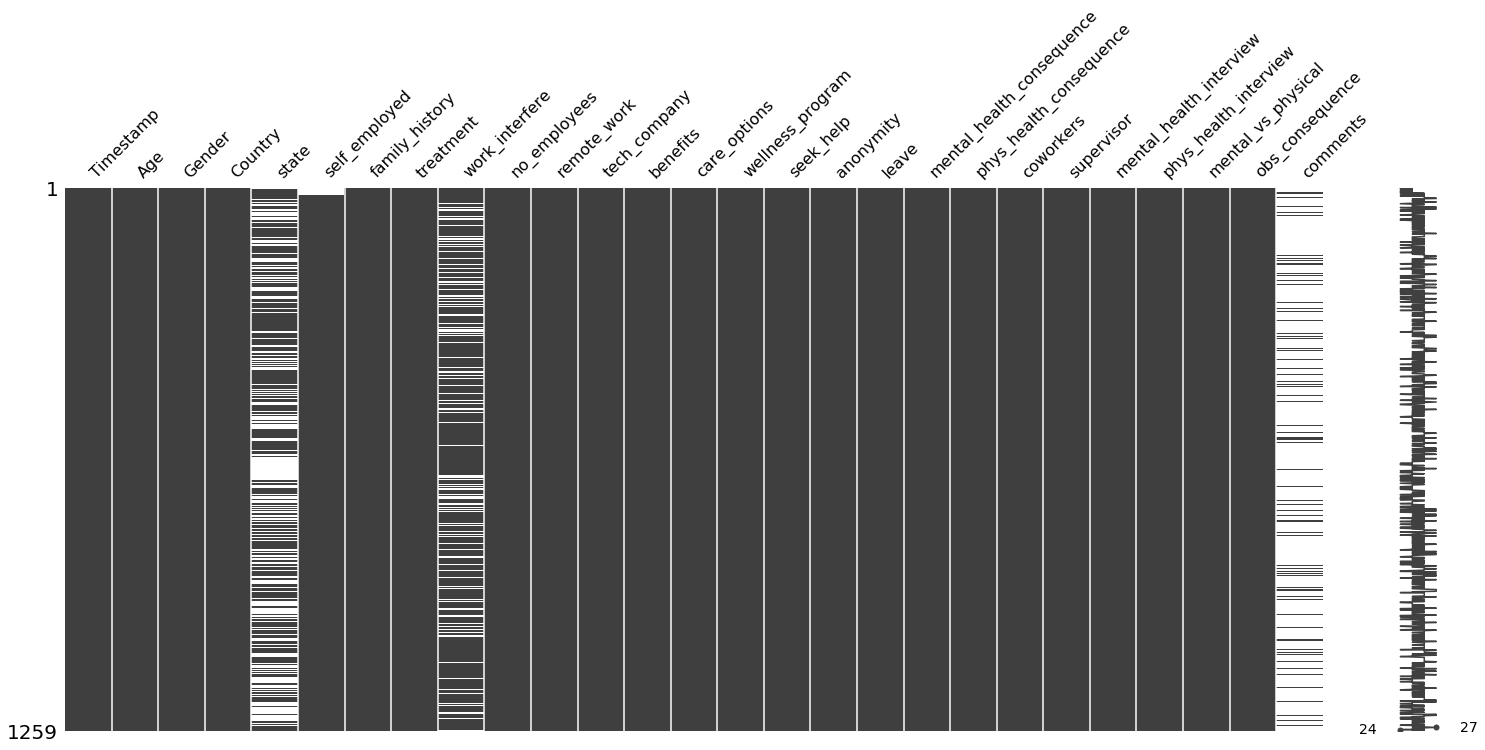

In [99]:
mn.matrix(data)

In [100]:
#data pre-processing 
cols_to_encode = ['Country','no_employees']
#categories in 'Gender'
print(data['Gender'].value_counts().head(15).index)

for c in data.columns[5:-1]:
    print(data[c].unique())

Index(['Male', 'male', 'Female', 'M', 'female', 'F', 'm', 'f', 'Make', 'Woman',
       'Male ', 'Cis Male', 'Female (trans)', 'Female ', 'Man'],
      dtype='object')
[nan 'Yes' 'No']
['No' 'Yes']
['Yes' 'No']
['Often' 'Rarely' 'Never' 'Sometimes' nan]
['6-25' 'More than 1000' '26-100' '100-500' '1-5' '500-1000']
['No' 'Yes']
['Yes' 'No']
['Yes' "Don't know" 'No']
['Not sure' 'No' 'Yes']
['No' "Don't know" 'Yes']
['Yes' "Don't know" 'No']
['Yes' "Don't know" 'No']
['Somewhat easy' "Don't know" 'Somewhat difficult' 'Very difficult'
 'Very easy']
['No' 'Maybe' 'Yes']
['No' 'Yes' 'Maybe']
['Some of them' 'No' 'Yes']
['Yes' 'No' 'Some of them']
['No' 'Yes' 'Maybe']
['Maybe' 'No' 'Yes']
['Yes' "Don't know" 'No']
['No' 'Yes']


In [101]:
male = ['Male', 'male',  'M',  'm', 'Make', 'Male ', 'Cis Male',  'Man']
female = ['Female','female', 'F','f', 'Woman','Female (trans)', 'Female ']
others = list(data['Gender'].value_counts().tail(34).index)

def set_gender(sex):
    if sex in male:
        return 0
    elif sex in female:
        return 1
    else:
        return 2
    
def set_binary(k):
    if k == 'Yes':
        return 1
    elif k == 'No':
        return 0
    elif k in ('Maybe',"Don't know","Some of them"):
        return 2
    else:
        return 3 #for None

def set_leave(s):
    if s == 'Somewhat easy':
        return 0
    elif s =="Don't know":
        return 1
    elif s == 'Somewhat difficult':
        return 2
    elif s == 'Very difficult':
        return 3
    elif s == 'Very easy':
        return 4
#droppin missing rows
#data.dropna(inplace = True) #don't need this caz I'm setting it in apply()

#drop columns
cols_to_drop = ['work_interfere','Timestamp','state','comments']
data.drop(labels=cols_to_drop, axis =1, inplace=True)

#handling 'Age' col
data = data[(data['Age']<100) & (data['Age']>1)]

print('Updated Gender split:\n',data['Gender'].apply(set_gender).value_counts())
data['Gender'] = data['Gender'].apply(set_gender)

col_apply = ['self_employed','family_history','treatment', 'remote_work','tech_company' , 
            'benefits', 'care_options', 'wellness_program', 'seek_help','anonymity', 'mental_health_consequence' ,
            'phys_health_consequence','coworkers','supervisor', 'mental_health_interview','phys_health_interview',
            'mental_vs_physical', 'obs_consequence' ] 

for c in col_apply:
    #print(data[c].apply(set_binary).value_counts())
    data[c] = data[c].apply(set_binary)

data[1:].describe()

Updated Gender split:
 0    979
1    243
2     32
Name: Gender, dtype: int64


,Age,Gender,self_employed,family_history,treatment,remote_work,tech_company,benefits,care_options,wellness_program,seek_help,anonymity,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
count,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000
mean,32.015164,0.244214,0.155626,0.391061,0.504389,0.297686,0.819633,1.028731,1.101357,0.480447,0.776536,1.600160,0.990423,0.482841,1.409417,0.968077,0.363927,1.046289,1.188348,0.145251
std,7.376605,0.485633,0.461499,0.488183,0.500180,0.457423,0.384646,0.788782,1.178253,0.740634,0.868066,0.585146,0.877426,0.828256,0.808782,0.768137,0.749893,0.915484,0.832425,0.352495
min,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,31.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,2.000000,1.000000,0.000000,2.000000,1.000000,0.000000,1.000000,1.000000,0.000000
75%,36.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,0.000000,2.000000,2.000000,0.000000
max,72.000000,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000,2.000000,3.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000


In [102]:
len(data), len(data.dropna())

(1254, 1254)

In [ ]:
#label encoder

In [104]:
data.corr()

,Age,Gender,self_employed,family_history,treatment,remote_work,tech_company,benefits,care_options,wellness_program,seek_help,anonymity,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
Age,1.000000,-0.091950,0.054127,0.009893,0.075266,0.139105,-0.060977,-0.046759,-0.016931,0.035729,0.039453,0.003441,0.041466,0.094281,-0.013896,-0.012576,-0.058567,-0.027911,-0.011381,0.065878
Gender,-0.091950,1.000000,0.001846,0.144826,0.170858,0.002454,-0.066939,0.027469,0.059093,0.034648,0.004824,-0.039583,0.084569,0.096968,-0.024040,0.046617,-0.104368,-0.095880,-0.035089,0.081305
self_employed,0.054127,0.001846,1.000000,0.002205,0.010402,0.224006,0.069519,-0.131177,0.002359,-0.004725,-0.064404,-0.086614,-0.087300,-0.023725,0.005990,-0.005958,0.100035,0.038507,-0.031263,0.039967
family_history,0.009893,0.144826,0.002205,1.000000,0.378069,0.015196,-0.049709,0.004008,-0.015819,-0.018176,0.008309,-0.072212,0.061636,0.036721,-0.011819,-0.000788,-0.068008,-0.062604,-0.092778,0.120100
treatment,0.075266,0.170858,0.010402,0.378069,1.000000,0.026919,-0.032859,-0.093438,-0.033992,-0.014826,-0.023280,-0.129790,0.088301,0.039706,0.024745,-0.007915,-0.089781,-0.036220,-0.115300,0.154541
remote_work,0.139105,0.002454,0.224006,0.015196,0.026919,1.000000,0.132627,-0.039194,-0.024232,0.009277,-0.011493,0.006916,-0.055949,0.023276,0.015348,-0.025233,0.075339,0.040889,0.037336,-0.040291
tech_company,-0.060977,-0.066939,0.069519,-0.049709,-0.032859,0.132627,1.000000,-0.043465,0.003959,-0.029447,-0.063294,0.065717,-0.104879,-0.072601,0.017029,0.015654,0.078023,0.028640,0.081145,-0.065964
benefits,-0.046759,0.027469,-0.131177,0.004008,-0.093438,-0.039194,-0.043465,1.000000,0.295585,0.240202,0.407143,0.248071,-0.005337,-0.097020,0.067899,-0.019578,0.020130,0.001444,0.177871,-0.109800
care_options,-0.016931,0.059093,0.002359,-0.015819,-0.033992,-0.024232,0.003959,0.295585,1.000000,0.259692,0.271317,0.101384,-0.036767,0.001441,0.031914,0.082089,0.007306,-0.023712,0.072989,-0.039808
wellness_program,0.035729,0.034648,-0.004725,-0.018176,-0.014826,0.009277,-0.029447,0.240202,0.259692,1.000000,0.472515,0.012879,-0.097964,-0.044827,0.056311,0.099948,0.066266,-0.060422,0.098059,-0.034782
